In [1]:
import gym

import torch
from torch import nn
from torch.nn import MSELoss
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
import random
from copy import deepcopy
from IPython.display import clear_output
import torch.nn.functional as F

In [2]:
device = torch.device("cpu")

In [3]:
env = gym.make("MountainCar-v0")
state = env.reset()

In [4]:
model = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 3)
)

target_model = deepcopy(model)


def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal(layer.weight)

model.apply(init_weights)

model.train()
target_model.train()
model.to(device)
target_model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00003)

/Users/aleksandrbutenko/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  


In [5]:
class D:
    def __init__(self, N):
        self.n = N
        self.memory = []
    def add(self, element):
        self.memory.append(element)
        if self.n < len(self.memory):
            self.memory.pop(0)
            
    def batch(self,size):
        return random.sample(self.memory, size)
        

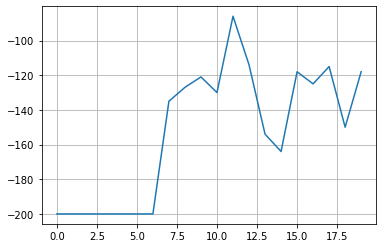

In [7]:
random.seed(1)

memory = D(5000)

rewards = []

state = env.reset()
for i in range(1, 20001):
    

    if random.random() < 1 - 0.9 * i / 20001:
        action = random.randint(0, 2)
    else:
        action = model(torch.tensor(state).float()).argmax().item()
        
    new_state, reward, done, _ = env.step(action)

    if done:
        memory.add((state, action, reward, state, done))
        state = env.reset()
        done = False
    else:

        memory.add((state, action, reward + 5 * abs(new_state[1]), new_state, done))
        state = new_state
    
    #study every step after we accumulate
    
    if i > 128:
        states, actions, rewardes, next_states,dones = list(zip(*memory.batch(128)))

        states = torch.tensor(states).to(device).float()
        next_states = torch.tensor(next_states).to(device).float()
        rewardes = torch.tensor(rewardes).to(device).float()
        actions = torch.tensor(actions)

        target = torch.zeros(rewardes.size()[0]).float()

        with torch.no_grad():
            target[dones] = target_model(next_states).max(1)[0][dones]

        target = rewardes + target * 0.99

        q = model(states).gather(1, actions.unsqueeze(1))
        loss = F.smooth_l1_loss(q, target.unsqueeze(1))

        optimizer.zero_grad()

        loss.backward()

        for params in model.parameters():
            params.grad.data.clamp_(-1, 1)

        optimizer.step()


    if i % 1000 == 0:
        target_model = deepcopy(model)
        state = env.reset()
        state = env.reset()
        rew = 0.
        done = False
        while not done:

            epsilon = 0.

            action = model(torch.tensor(state).float()).argmax().item()
            state, reward, done, _ = env.step(action)
            rew += reward
        rewards.append(rew)
        clear_output(True)
        plt.grid()
        plt.plot(list(range(len(rewards))), rewards)
        plt.show()
        

